In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cmap = matplotlib.cm.get_cmap('Spectral')
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.metrics import confusion_matrix

# Clasificacion

Vamos a hacer una introduccion a problemas de clasificacion adelantandonos nuevamente. Veamos como seria resolver un problema de clasificacion ingenuo con ayuda de sklearn en datos reales.

# El problema:

En esta cuarentena, estoy muy metido en la NBA. Con mi grupo de adictos, empezamos a charlar para matar el tiempo y me surgio una pregunta. ~Puedo hablar de basquet en vez de trabajar?~ Puedo mentir con seguridad sobre las estadisticas que leo en los articulos?

Para eso, me puse a explorar un poco. En primer lugar, necesito datos. Para eso, recurro a una pagina llamada basketballreference.com donde se almacenan todos los datos posibles. Para hacer las cosas mas simples, me voy a limitar a una unica temporada, en la que los roles posicionales son mas o menos los mismos en la liga (salvo en Houston) y no tengo jugadores repetidos (salvo los que fueron transferidos, pero ahora mismo no me interesa ser demasiado cauto en el procesado).

In [ ]:
from urllib.request import urlopen
from bs4 import BeautifulSoup

In [ ]:
BeautifulSoup?

In [ ]:
url = "https://www.basketball-reference.com/leagues/NBA_{}_advanced.html".format(2016)# this is the HTML from the given URL
html = urlopen(url)
soup = BeautifulSoup(html)

In [ ]:
soup.findAll('tr', limit=2)# use getText()to extract the text we need into a list
headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]# exclude the first column as we will not need the ranking order from Basketball Reference for the analysis

In [ ]:
headers = headers[1:]
rows = soup.findAll('tr')[1:]
player_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]
stats = pd.DataFrame(player_stats, columns = headers)
stats=stats.drop('\xa0',axis=1)

In [ ]:
stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 601 entries, 0 to 600
Data columns (total 26 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Player  578 non-null    object
 1   Pos     578 non-null    object
 2   Age     578 non-null    object
 3   Tm      578 non-null    object
 4   G       578 non-null    object
 5   MP      578 non-null    object
 6   PER     578 non-null    object
 7   TS%     578 non-null    object
 8   3PAr    578 non-null    object
 9   FTr     578 non-null    object
 10  ORB%    578 non-null    object
 11  DRB%    578 non-null    object
 12  TRB%    578 non-null    object
 13  AST%    578 non-null    object
 14  STL%    578 non-null    object
 15  BLK%    578 non-null    object
 16  TOV%    578 non-null    object
 17  USG%    578 non-null    object
 18  OWS     578 non-null    object
 19  DWS     578 non-null    object
 20  WS      578 non-null    object
 21  WS/48   578 non-null    object
 22  OBPM    578 non-null    ob

In [ ]:
stats.head()

,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,Quincy Acy,PF,25,SAC,59,876,14.7,.629,.229,.318,8.1,15.1,11.6,4.4,1.6,2.2,10.0,13.1,1.8,0.7,2.5,.137,-0.2,0.2,-0.1,0.4
1,Jordan Adams,SG,21,MEM,2,15,17.3,.427,.167,.833,0.0,15.9,7.6,31.9,10.3,0.0,19.6,30.5,0.0,0.0,0.0,.015,-2.5,9.4,6.9,0.0
2,Steven Adams,C,22,OKC,80,2014,15.5,.621,.000,.460,12.5,16.1,14.4,4.3,1.0,3.3,14.1,12.6,4.2,2.3,6.5,.155,0.0,0.2,0.2,1.1
3,Arron Afflalo,SG,30,NYK,71,2371,10.9,.531,.298,.164,1.1,11.0,6.1,9.9,0.5,0.3,8.7,17.9,1.8,0.9,2.7,.055,-1.3,-1.6,-2.9,-0.5
4,Alexis Ajinça,C,27,NOP,59,861,13.8,.514,.003,.197,9.3,25.9,17.3,5.8,1.1,3.4,13.6,20.4,0.2,0.9,1.0,.058,-3.4,-0.6,-4.0,-0.4


In [ ]:
stats[stats['Tm']=='TOT']['Player']

12       Chris Andersen
29        D.J. Augustin
73       Chase Budinger
93       Mario Chalmers
107        Bryce Cotton
117    Jared Cunningham
148         James Ennis
163          Randy Foye
166         Tim Frazier
169     Jimmer Fredette
172       Channing Frye
197         Erick Green
202          Jeff Green
207       P.J. Hairston
221       Tobias Harris
233        J.J. Hickson
241        Kirk Hinrich
246      Justin Holiday
249        Ryan Hollins
259      Kris Humphries
266      Ersan İlyasova
279        John Jenkins
282    Brandon Jennings
289         Joe Johnson
292     Orlando Johnson
313     Sean Kilpatrick
324           Ty Lawson
327        Courtney Lee
331           David Lee
347        Shelvin Mack
356        Kevin Martin
363        Ray McCallum
374        Jordan McRae
384        Andre Miller
398     Markieff Morris
418         Steve Novak
454        Phil Pressey
467       Brian Roberts
483      JaKarr Sampson
500           Ish Smith
505          Josh Smith
513    Lance Ste

En particular, todo a partir de OWS son estadisticas que me hablan de "cuan bueno es un jugador", y estan obtenidas con ciertas combinaciones de las previas.

En particular, yo me quiero plantear el siguiente problema. Que tan bien tienen que jugar los jugadores para clasificar a Playoffs? 

In [ ]:
teams=stats['Tm'].unique()
teams

In [ ]:
stats['G'].unique()

array(['59', '2', '80', '71', '60', '74', '8', '79', '64', '82', '29',
       '27', '7', '20', '13', '51', '55', '78', '66', None, '72', '19',
       '5', '81', '70', '68', '62', '34', '28', '17', '47', '18', '46',
       '76', '52', '75', '39', '58', '31', '30', '53', '69', '49', '37',
       '67', '6', '77', '26', '54', '61', '1', '3', '45', '56', '24',
       '65', '73', '44', '40', '4', '43', '14', '12', '22', '10', '9',
       '25', '35', '16', '38', '57', '48', '11', '21', '15', '32', '36',
       '23', '50', '41', '42', '63', '33'], dtype=object)

In [ ]:
no_playoff_west=np.asarray(['SAC','DEN','LAL','MIN','PHO','UTA','NOP'])
print(len(no_playoff_west))
playoff_west=np.asarray(['GSW','SAS','OKC','LAC','POR','DAL','MEM','HOU'])
print(len(playoff_west))

no_playoff_east=np.asarray(['CHI','WAS','ORL','MIL','NYK','BRK','PHI'])
print(len(no_playoff_east))
playoff_east=np.asarray(['CLE','TOR','MIA','ATL','BOS','CHO','IND','DET'])
print(len(playoff_east))

7
8
7
8


In [ ]:
stats['Pos'].value_counts()

PG       129
PF       122
SG       116
SF       105
C        104
PF-C       1
SG-SF      1
Name: Pos, dtype: int64

# El procesado

En principio, yo tengo mi dataframe y ahora lo unico que voy a hacer es separar en Train y Test y luego asignarles las clases. En particular, voy considerar jugadores que jugaron cierta cantidad de los partidos al menos cierta cantidad de minutos y que participaron mucho del partido.

In [ ]:
stats_now=stats.copy()
print(len(stats_now)-sum(stats_now['Pos'].isnull()))
print(np.sum(stats_now['Pos'].isin(['SG','PF','PG','C','SF'])))

578
576


In [ ]:
stats_now=stats.copy()
stats_now=stats_now[stats_now['Pos'].isin(['SG','PF','PG','C','SF'])]
stats_now["G"]=pd.to_numeric(stats_now["G"])
stats_now["MP"]=pd.to_numeric(stats_now["MP"])
stats_now["USG%"]=pd.to_numeric(stats_now["USG%"])
stats_now=stats_now[stats_now["USG%"]>stats_now["USG%"].mean()]
stats_now["MPperG"]=stats_now["MP"]/stats_now["G"]
stats_now=stats_now[stats_now["G"]>=20]
stats_now=stats_now[stats_now["MPperG"]>=25]
stats_now=stats_now[stats_now["Tm"]!="TOT"]

In [ ]:
stats_now=stats_now.replace(['PG','SG','SF','PF','C'],[1,2,3,4,5])
stats_now['Pos'].value_counts()

1    29
2    26
4    19
3    19
5    15
Name: Pos, dtype: int64

Generemos los labels. Voy a aplicar el siguiente codigo:

0: no playoff oeste
1: playoff oeste
2: no playoff este
3: playoff este

0    30
2    28
3    26
1    24
Name: label, dtype: int64


(array([ 1.,  0.,  4.,  0., 10.,  0.,  7.,  0.,  7.,  1.]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <a list of 10 Patch objects>)

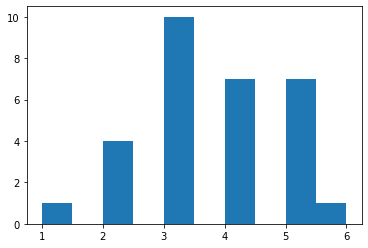

In [ ]:
stats_now['label']=stats_now["Tm"]
stats_now['label']=stats_now['label'].replace(no_playoff_west,0)
stats_now['label']=stats_now['label'].replace(playoff_west,1)
stats_now['label']=stats_now['label'].replace(no_playoff_east,2)
stats_now['label']=stats_now['label'].replace(playoff_east,3)
print(stats_now['label'].value_counts())
plt.hist(stats_now['Tm'].value_counts())

In [ ]:
stats_now.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108 entries, 6 to 598
Data columns (total 28 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  108 non-null    object 
 1   Pos     108 non-null    int64  
 2   Age     108 non-null    object 
 3   Tm      108 non-null    object 
 4   G       108 non-null    int64  
 5   MP      108 non-null    int64  
 6   PER     108 non-null    object 
 7   TS%     108 non-null    object 
 8   3PAr    108 non-null    object 
 9   FTr     108 non-null    object 
 10  ORB%    108 non-null    object 
 11  DRB%    108 non-null    object 
 12  TRB%    108 non-null    object 
 13  AST%    108 non-null    object 
 14  STL%    108 non-null    object 
 15  BLK%    108 non-null    object 
 16  TOV%    108 non-null    object 
 17  USG%    108 non-null    float64
 18  OWS     108 non-null    object 
 19  DWS     108 non-null    object 
 20  WS      108 non-null    object 
 21  WS/48   108 non-null    object 
 22  OB

Bien, ahora definamos las caracteristicas que voy a utilizar. Para visualizar facilmente voy a elegir unicamente dos: PER y USG%. Guardo ademas el nombre, la posicion y el label.

In [ ]:
stats_now=stats_now[['Player','Pos','PER','USG%','label']]
stats_now['PER']=pd.to_numeric(stats_now['PER'])
stats_now['USG%']=pd.to_numeric(stats_now['USG%'])

In [ ]:
print(stats_now.iloc[np.where(stats_now["Player"]=="LeBron James")])
print(stats_now.iloc[np.where(stats_now["Player"]=="Will Barton")])

           Player  Pos   PER  USG%  label
275  LeBron James    3  27.5  31.4      3
         Player  Pos   PER  USG%  label
40  Will Barton    2  16.0  23.0      0


Veamos si hay jugadores repetidos:

Tobias Harris      2
Jeff Green         2
Gordon Hayward     1
Derrick Favors     1
Bradley Beal       1
                  ..
Markieff Morris    1
John Wall          1
Shelvin Mack       1
Isaiah Thomas      1
Kawhi Leonard      1
Name: Player, Length: 106, dtype: int64


(array([104.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.]),
 array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <a list of 10 Patch objects>)

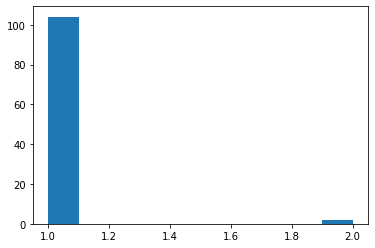

In [ ]:
print(stats_now['Player'].value_counts())
plt.hist(stats_now['Player'].value_counts())

Los hay pero son pocos por lo que no me voy a gastar en corregirlo.


Dividamos en train y test. Como cada posicion es un mundo, voy a estratificar para que train y test tengan mismas proporciones de cada posicio



In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=445543)
for train_index, test_index in split.split(stats_now, stats_now["Pos"]):
    strat_train_set = stats_now.iloc[train_index]
    strat_test_set = stats_now.iloc[test_index]

In [ ]:
stats_train = strat_train_set.drop(["Player","Pos","label"], axis=1) # drop labels for training set
stats_train_labels = strat_train_set["label"].copy()
stats_test = strat_test_set.drop(["Player","Pos","label"], axis=1) # drop labels for training set
stats_test_labels = strat_test_set["label"].copy()


Veamos cuantos datos tengo para clasificar:

In [ ]:
print(len(stats_train))

86


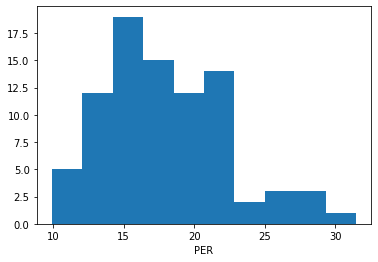

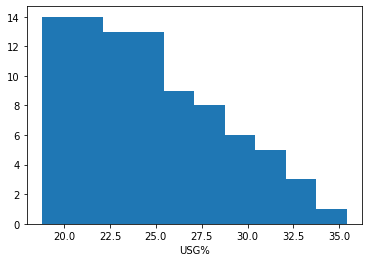

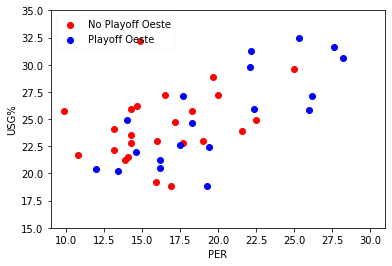

(15.0, 35.0)

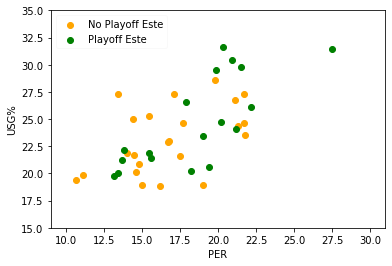

In [ ]:
plt.hist(stats_train['PER'],bins=10)
plt.xlabel(r'PER')
plt.show()
plt.hist(stats_train['USG%'],bins=10)
plt.xlabel(r'USG%')
plt.show()
plt.scatter(stats_train['PER'][stats_train_labels==0],stats_train['USG%'][stats_train_labels==0], c='red', label="No Playoff Oeste")
plt.scatter(stats_train['PER'][stats_train_labels==1],stats_train['USG%'][stats_train_labels==1], c='blue', label="Playoff Oeste")
plt.legend(loc='upper left',framealpha =0.1)
plt.xlim(9.0,31.0)
plt.ylim(15.0,35.0)
plt.xlabel(r'PER')
plt.ylabel('USG%')
plt.show()
plt.scatter(stats_train['PER'][stats_train_labels==2],stats_train['USG%'][stats_train_labels==2], c='orange', label="No Playoff Este")
plt.scatter(stats_train['PER'][stats_train_labels==3],stats_train['USG%'][stats_train_labels==3], c='green', label="Playoff Este")
plt.legend(loc='upper left',framealpha =0.1)
plt.xlabel(r'PER')
plt.ylabel('USG%')
plt.xlim(9.0,31.0)
plt.ylim(15.0,35.0)

En el Oeste, esperaria tener muy pocos falsos positivos pero una gran cantidad de falsos negativos. En el Este pasa lo mismo pero menos pronunciado.

In [ ]:
print(strat_train_set[strat_train_set["PER"]<12.0])
print(strat_train_set[strat_train_set["PER"]>25.0])

               Player  Pos   PER  USG%  label
101       Norris Cole    1  10.8  21.7      0
58   Bojan Bogdanović    3  10.7  19.4      2
85      Isaiah Canaan    2  11.1  19.9      2
404   Emmanuel Mudiay    1   9.9  25.7      0
                Player  Pos   PER  USG%  label
438         Chris Paul    1  26.2  27.1      1
213       James Harden    2  25.3  32.5      1
575  Russell Westbrook    1  27.6  31.6      1
275       LeBron James    3  27.5  31.4      3
335      Kawhi Leonard    3  26.0  25.8      1
143       Kevin Durant    3  28.2  30.6      1
121      Stephen Curry    1  31.5  32.6      1


#Clasificacion

Entrenemos un clasificador, para Este y Oeste separados.

In [ ]:
X_este=np.asarray(strat_train_set[(stats_train_labels==2) | (stats_train_labels==3)][["PER","USG%"]])
print(X_este.shape)
y_este=np.asarray(strat_train_set[(stats_train_labels==2) | (stats_train_labels==3)][["label"]])
y_este=np.where(y_este==2,0,1)[:,0]
print(y_este.shape)

X_oeste=np.asarray(strat_train_set[(stats_train_labels==0) | (stats_train_labels==1)][["PER","USG%"]])
print(X_oeste.shape)
y_oeste=np.asarray(strat_train_set[(stats_train_labels==0) | (stats_train_labels==1)][["label"]])
print(y_oeste.shape)

(41, 2)
(41,)
(45, 2)
(45, 1)


El primer algoritmo importante que vamos a ver es Discriminante Lineal de Fisher. El objetivo del algoritmo, que es ademas un ejemplo de reduccion dimensional, es encontrar las componentes que minimizen la varianza intraclase y maximizen la varianza entre clases.

Para el caso de 2 clases, el discriminante lineal de fisher busca encontrar los coeficientes $w$ tales que la funcion discriminante es

$y=w_{0}+\vec{w}^{T}\cdot \vec{x}$

Y la superficie de decision usual es $y=0$. $w_{0}$ es el `intercept_` y $\vec{w}$ el vector de `coef_`.


In [ ]:
LDA_este=LinearDiscriminantAnalysis(solver='eigen')
LDA_este.fit(X_este,y_este)
print(LDA_este.intercept_,LDA_este.coef_)
#LDA_este.intercept_+=-1.0

[-3.56360439] [[0.10776742 0.05911706]]


Grafiquemos un poco los valores posibles

Text(0, 0.5, 'USG%')

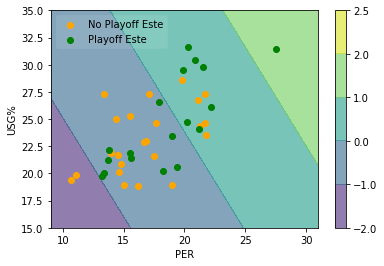

In [ ]:
x=np.linspace(9.0,31.0,100)
y=np.linspace(15.0,35.0,100)
Xtoplot,Ytoplot=np.meshgrid(x,y)
plt.xlim(9.0,31.0)
plt.ylim(15.0,35.0)
Z=LDA_este.intercept_ + LDA_este.coef_[0,0]*Xtoplot+LDA_este.coef_[0,1]*Ytoplot
plt.contourf(Xtoplot,Ytoplot,Z,levels=[-2.0,-1.0,0.0,1.0,2.0,2.5],alpha=0.6)
plt.colorbar()
plt.scatter(stats_train['PER'][stats_train_labels==2],stats_train['USG%'][stats_train_labels==2], c='orange', label="No Playoff Este")
plt.scatter(stats_train['PER'][stats_train_labels==3],stats_train['USG%'][stats_train_labels==3], c='green', label="Playoff Este")
plt.legend(loc='upper left',framealpha =0.1)
plt.xlabel(r'PER')
plt.ylabel('USG%')

Otra manera de obtener la funcion de decision es usando... `decision_function`

Text(0, 0.5, 'USG%')

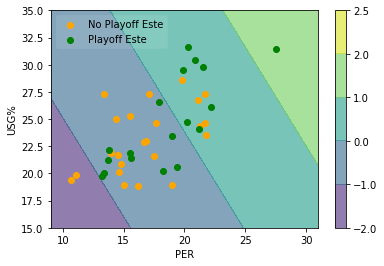

In [ ]:
x=np.linspace(9.0,31.0,100)
y=np.linspace(15.0,35.0,100)
Xtoplot,Ytoplot=np.meshgrid(x,y)
plt.xlim(9.0,31.0)
plt.ylim(15.0,35.0)
Z=LDA_este.decision_function(np.c_[Xtoplot.ravel(), Ytoplot.ravel()]).reshape(Xtoplot.shape)
plt.contourf(Xtoplot,Ytoplot,Z,levels=[-2.0,-1.0,0.0,1.0,2.0,2.5],alpha=0.6)
plt.colorbar()
plt.scatter(stats_train['PER'][stats_train_labels==2],stats_train['USG%'][stats_train_labels==2], c='orange', label="No Playoff Este")
plt.scatter(stats_train['PER'][stats_train_labels==3],stats_train['USG%'][stats_train_labels==3], c='green', label="Playoff Este")
plt.legend(loc='upper left',framealpha =0.1)
plt.xlabel(r'PER')
plt.ylabel('USG%')

In [ ]:
LDA_este.decision_function(X_este[0,:].reshape(1,-1))

array([-0.7063715])

Podemos asignar las clases utilizando la funcion de decision. sklearn nos lo provee con `predict` donde el umbral esta en $y=0$.

Text(0, 0.5, 'USG%')

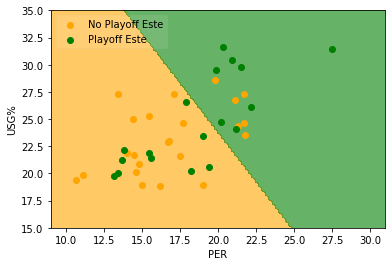

In [ ]:
x=np.linspace(9.0,31.0,100)
y=np.linspace(15.0,35.0,100)
Xtoplot,Ytoplot=np.meshgrid(x,y)
plt.xlim(9.0,31.0)
plt.ylim(15.0,35.0)
Z=LDA_este.predict(np.c_[Xtoplot.ravel(), Ytoplot.ravel()]).reshape(Xtoplot.shape)
plt.contourf(Xtoplot,Ytoplot,Z,levels=[0.0,0.5,1.0],colors=['orange','green'],alpha=0.6)
plt.scatter(stats_train['PER'][stats_train_labels==2],stats_train['USG%'][stats_train_labels==2], c='orange', label="No Playoff Este")
plt.scatter(stats_train['PER'][stats_train_labels==3],stats_train['USG%'][stats_train_labels==3], c='green', label="Playoff Este")
plt.legend(loc='upper left',framealpha=0.1)
plt.xlabel(r'PER')
plt.ylabel('USG%')

Si mi umbral esta ahora en $y=y_{1}$

$y_{1}=w_{0}+w_{1}x_{1}+w_{2}x_{2}$

$0=w_{0}-y_{1}+w_{1}x_{1}+w_{2}x_{2}$

Redefino mi sesgo como $w_{0}-y_{1}$

$0=w^{'}_{0}+w_{1}x_{1}+w_{2}x_{2}$


Una vez asignamos las clases, podemos calcular matriz de confusion y con eso distintas metricas

Matriz de confusion: Cada fila corresponde a una clase y cada columna corresponde a una asignacion.

In [ ]:
cf_este=confusion_matrix(y_este,LDA_este.predict(X_este))
print(cf_este)
tn, fp, fn, tp = cf_este.ravel()
print("Sensitividad (TPR/Recall):%8.3f" % (tp/(tp+fn)))
print("Especificidad:%8.3f" % (tn/(tn+fp)))
print("Precision:%8.3f" % (tp/(tp+fp)))
print("FPR:%8.3f" % (fp/(tn+fp)))

[[17  6]
 [10  8]]
Sensitividad (TPR/Recall):   0.444
Especificidad:   0.739
Precision:   0.571
FPR:   0.261


De todas maneras, no tenemos demasiados datos pero podemos ver que lo mas alto es la especificidad. Es decir, no solemos asignar como positivos a los verdaderos negativos. Lo peor que tenemos es la sensitividad, que nos dice cuantos positivos nos perdemos. La precision nos dice cuan seguros podemos estar de un positivo.

El segundo algoritmo es el Perceptron Multicapa, que tambien obtiene una funcion discriminante. 

$y=f(\vec{w}^{T}\cdot\vec{\phi}(\vec{x}))$

Con $f(a)=\frac{a}{|a|}$ y por convencion $\phi_0(\vec{x})=1$.

El Perceptron se resuelve con algoritmo iterativo que solo tiene asegurada la convergencia para problemas linealmente separables, que no es el caso. Sin embargo, ya que estamos probemoslo.

In [ ]:
Percep_este=Perceptron()
Percep_este.fit(X_este,y_este)
print(Percep_este.intercept_,Percep_este.coef_)

[-4.] [[18.4 15.3]]


Como es un algoritmo que busca la funcion discriminante, se puede hacer lo mismo que hicimos para LDA.

El tercero es el de Regresion Logistica. A diferencia de los anteriores, este es un algoritmo que, bajo ciertas hipotesis, busca recuperar el posterior de la clase. Es decir, obtiene una probabilidad para cada clase. 

$y_{k}(\vec{w},\vec{x})=p(k|\vec{w},\vec{x})$


Es un ejemplo de un algoritmo discriminativo. En principio, se necesitan tantas funciones $y$ como clases. Sin embargo, el caso de 2 clases provee una simplificacion ya que como son probabilidades, $y_{0}+y_{1} = 1$. Entonces, llamo $y$ a $y_{1}$ y puedo escribir de manera compacta.

$t=0,1$

$p(t|\vec{x},\vec{w})=y(\vec{x},\vec{w})^{t}(1-y(\vec{x},\vec{w}))^{1-t}$

$y(\vec{w},\vec{x})=\sigma(\vec{w}^{T}\cdot\vec{\phi}(\vec{x}))$

Donde $\sigma$ es la funcion sigmoide.

Ahora la superficie de decision estara, para dos clases, en la recta de equiprobabilidad 

$p(0|\vec{w},\vec{x})=p(1|\vec{w},\vec{x})$

$1-y=y$

$y=0.5$

El error que se minimiza en este caso no es el de cuadrados minimos sino que es el de la entropia cruzada (_cross-entropy_):


$E(\vec{w})=-\sum_{n=1}^{N}(t_{n}\text{ln}(y_{n})+(1-t_{n})\text{ln}(1-y_{n}))$

Ya no se puede minimizar esto analiticamente pero se puede hacer de manera numerica.

In [ ]:
logistic_este=LogisticRegression()
logistic_este.fit(X_este,y_este)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Ahora, ademas de funcion de decision, tenemos probabilidaes:



In [ ]:
proba=logistic_este.predict_proba(X_este)
print(proba.shape)
print(proba[0],y_este[0])

(41, 2)
[0.66550955 0.33449045] 0


Y tambien tenemos la opcion predict, tal como antes:

Text(0, 0.5, 'USG%')

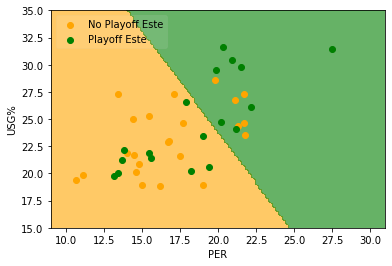

In [ ]:
x=np.linspace(9.0,31.0,100)
y=np.linspace(15.0,35.0,100)
Xtoplot,Ytoplot=np.meshgrid(x,y)
plt.xlim(9.0,31.0)
plt.ylim(15.0,35.0)
Z=logistic_este.predict(np.c_[Xtoplot.ravel(), Ytoplot.ravel()]).reshape(Xtoplot.shape)
plt.contourf(Xtoplot,Ytoplot,Z,levels=[0.0,0.5,1.0],colors=['orange','green'],alpha=0.6)
plt.scatter(stats_train['PER'][stats_train_labels==2],stats_train['USG%'][stats_train_labels==2], c='orange', label="No Playoff Este")
plt.scatter(stats_train['PER'][stats_train_labels==3],stats_train['USG%'][stats_train_labels==3], c='green', label="Playoff Este")
plt.legend(loc='upper left',framealpha =0.1)
plt.xlabel(r'PER')
plt.ylabel('USG%')

Podemos sacar mas informacion viendo la matriz de confusion

In [ ]:
from sklearn.metrics import confusion_matrix
cf_este=confusion_matrix(y_este,logistic_este.predict(X_este))
print(cf_este)
tn, fp, fn, tp = cf_este.ravel()
print("Sensitividad (TPR/Recall):%8.3f" % (tp/(tp+fn)))
print("Especificidad:%8.3f" % (tn/(tn+fp)))
print("Precision:%8.3f" % (tp/(tp+fp)))
print("FPR:%8.3f" % (fp/(tn+fp)))

[[17  6]
 [10  8]]
Sensitividad (TPR/Recall):   0.444
Especificidad:   0.739
Precision:   0.571
FPR:   0.261


Ya que tenemos probabilidades, yo me siento comodo jugando un poco con los umbrales de decision:

Text(0, 0.5, 'USG%')

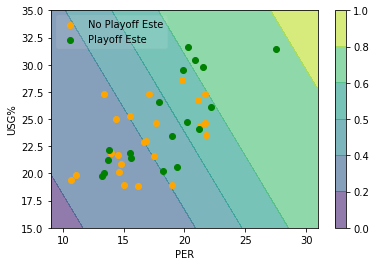

In [ ]:
x=np.linspace(9.0,31.0,100)
y=np.linspace(15.0,35.0,100)
Xtoplot,Ytoplot=np.meshgrid(x,y)
plt.xlim(9.0,31.0)
plt.ylim(15.0,35.0)
Z=logistic_este.predict_proba(np.c_[Xtoplot.ravel(), Ytoplot.ravel()])[:,1].reshape(Xtoplot.shape)
plt.contourf(Xtoplot,Ytoplot,Z,levels=[0.0,0.2,0.4,0.5,0.6,0.8,1.0],alpha=0.6)
plt.colorbar()
plt.scatter(stats_train['PER'][stats_train_labels==2],stats_train['USG%'][stats_train_labels==2], c='orange', label="No Playoff Este")
plt.scatter(stats_train['PER'][stats_train_labels==3],stats_train['USG%'][stats_train_labels==3], c='green', label="Playoff Este")
plt.legend(loc='upper left',framealpha =0.1)
plt.xlabel(r'PER')
plt.ylabel('USG%')

(20,)


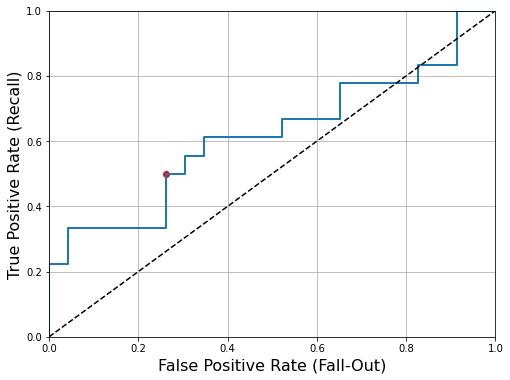

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_este, logistic_este.predict_proba(X_este)[:,1])
print(tpr.shape)
plt.figure(figsize=(8, 6))                         # Not shown
plt.plot(fpr, tpr, linewidth=2, label=None)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.axis([0, 1, 0, 1])
plt.scatter(fpr[np.argmin(np.abs(thresholds-0.5))],tpr[np.argmin(np.abs(thresholds-0.5))],color='red')                                    # Not shown in the book
plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
plt.grid(True)                                            # Not shown
plt.show()

## Y si quiero mas inputs?

Bueno, en principio puedo elegir mas inputs

In [ ]:
stats_now=stats_now[['Player','Pos','PER','USG%','TS%','3PAr','FTr','ORB%','DRB%','TRB%','AST%','STL%','BLK%','TOV%','label']]
for e in ['PER','USG%','TS%','3PAr','FTr','ORB%','DRB%','TRB%','AST%','STL%','BLK%','TOV%']:
  stats_now[e]=pd.to_numeric(stats_now[e])

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=445543)
for train_index, test_index in split.split(stats_now, stats_now["Pos"]):
    strat_train_set = stats_now.iloc[train_index]
    strat_test_set = stats_now.iloc[test_index]

In [ ]:
stats_train = strat_train_set.drop(["Player","Pos","label"], axis=1) # drop labels for training set
stats_train_labels = strat_train_set["label"].copy()
stats_test = strat_test_set.drop(["Player","Pos","label"], axis=1) # drop labels for training set
stats_test_labels = strat_test_set["label"].copy()

In [ ]:
X_este=np.asarray(stats_train[(stats_train_labels==2) | (stats_train_labels==3)])
print(X_este.shape)
y_este=np.asarray(strat_train_set[(stats_train_labels==2) | (stats_train_labels==3)][["label"]])
y_este=np.where(y_este==2,0,1)[:,0]
print(y_este.shape)

X_oeste=np.asarray(stats_train[(stats_train_labels==0) | (stats_train_labels==1)])
print(X_oeste.shape)
y_oeste=np.asarray(strat_train_set[(stats_train_labels==0) | (stats_train_labels==1)][["label"]])
print(y_oeste.shape)

In [ ]:
scaler=StandardScaler()
X_este_tr=scaler.fit_transform(X_este)
LDA_este_multi=LinearDiscriminantAnalysis(solver='eigen')
LDA_este_multi.fit(X_este_tr,y_este)

In [ ]:
from sklearn.metrics import confusion_matrix
cf_este=confusion_matrix(y_este,LDA_este_multi.predict(X_este_tr))
print(cf_este)
tn, fp, fn, tp = cf_este.ravel()
print("Sensitividad:%8.3f" % (tp/(tp+fn)))
print("Especificidad:%8.3f" % (tn/(tn+fp)))
print("Precision:%8.3f" % (tp/(tp+fp)))

Funciona mejor! Pero para plottear, hay que marginalizar en las otras variables.

Una alternativa es utilizar herramientas de reduccion de dimensionalidad. LDA es una de ellas, que baja de 12 features a 1.

In [ ]:
LDA_este_multi.decision_function(X_este_tr).shape
plt.hist(LDA_este_multi.decision_function(X_este_tr[y_este==0]),color='orange',histtype='step',label='No playoff este')
plt.hist(LDA_este_multi.decision_function(X_este_tr[y_este==1]),color='green',histtype='step',label='Playoff este')
plt.axvline(x=0,color='black',label='Frontera de decision')
plt.legend(loc='upper left',framealpha=0.6)

Una alternativa es usar Principal Component analysis (PCA) para bajar de 12 a 2

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_este_pca=pca.fit_transform(X_este)
X_este_pca.shape

In [ ]:
plt.hist(X_este_pca[:,0],bins=10)
plt.xlabel(r'PCA 1')
plt.show()
plt.hist(X_este_pca[:,1],bins=10)
plt.xlabel(r'PCA 2')
plt.show()
plt.scatter(X_este_pca[y_este==0,0],X_este_pca[y_este==0,1], c='orange', label="No Playoff Este")
plt.scatter(X_este_pca[y_este==1,0],X_este_pca[y_este==1,1], c='green', label="Playoff Oeste")
plt.legend(loc='upper left',framealpha =0.1)
#plt.xlim(9.0,31.0)
#plt.ylim(15.0,35.0)
plt.xlabel(r'PCA 1')
plt.ylabel('PCA 2')
plt.show()

In [ ]:
LDA_este_pca=LinearDiscriminantAnalysis(solver='eigen')
LDA_este_pca.fit(X_este_pca,y_este)

In [ ]:
x=np.linspace(-25.0,25.0,100)
y=np.linspace(-15.0,15.0,100)
Xtoplot,Ytoplot=np.meshgrid(x,y)
plt.xlim(-25.0,25.0)
plt.ylim(-15.0,15.0)
Z=LDA_este_pca.predict(np.c_[Xtoplot.ravel(), Ytoplot.ravel()]).reshape(Xtoplot.shape)
plt.contourf(Xtoplot,Ytoplot,Z,levels=[0.0,0.5,1.0],colors=['orange','green'],alpha=0.6)
plt.scatter(X_este_pca[y_este==0,0],X_este_pca[y_este==0,1], c='orange', label="No Playoff Este")
plt.scatter(X_este_pca[y_este==1,0],X_este_pca[y_este==1,1], c='green', label="Playoff Oeste")
plt.legend(loc='upper left',framealpha =0.1)
plt.xlabel(r'PCA 1')
plt.ylabel('PCA 2')

In [ ]:
from sklearn.metrics import confusion_matrix
cf_este=confusion_matrix(y_este,LDA_este_pca.predict(X_este_pca))
print(cf_este)
tn, fp, fn, tp = cf_este.ravel()
print("Sensitividad (TPR/Recall) :%8.3f" % (tp/(tp+fn)))
print("Especificidad:%8.3f" % (tn/(tn+fp)))
print("Precision:%8.3f" % (tp/(tp+fp)))
print("FPR :%8.3f" % (fp/(tn+fp)))

In [ ]:
from sklearn.preprocessing import MinMaxScaler
minmax=MinMaxScaler()
print(LDA_este_pca.decision_function(X_este_pca).min(),LDA_este_pca.decision_function(X_este_pca).max())
decision=minmax.fit_transform(LDA_este_pca.decision_function(X_este_pca).reshape(-1,1))
print(decision.min(),decision.max())

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_este, LDA_este_pca.decision_function(X_este_pca))
print(thresholds[0],thresholds[-1])
plt.figure(figsize=(8, 6))                         # Not shown
plt.plot(fpr, tpr, linewidth=2, label=None)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.axis([0, 1, 0, 1])
plt.scatter(fpr[np.argmin(np.abs(thresholds-0.0))],tpr[np.argmin(np.abs(thresholds-0.0))],color='red')                                    # Not shown in the book
plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
plt.grid(True)                                            # Not shown
plt.show()

# Test